# Notebook to train CNNs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler
import os
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import time
from pathlib import Path
from sklearn.metrics import balanced_accuracy_score, f1_score, matthews_corrcoef, roc_auc_score, accuracy_score, recall_score
from data_utils_torch import get_paths_and_labels, calculate_min_max, create_dataloader, extract_subject_id, clean_zone_identifier_files
from plotting_utils_torch import plot_loss_curves, make_confusion_matrix, view_image_data
from sklearn.model_selection import StratifiedGroupKFold
import gc
from tqdm.auto import tqdm
from monai.networks.nets import ResNet
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility    
seed = 10
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# Set mixed precision     
USE_AMP = True if device.type == 'cuda' else False
scaler = GradScaler(enabled=USE_AMP)
print(f"Automatic Mixed Precision (AMP) enabled: {USE_AMP}")

clean_zone_identifier_files("/home/diogommiranda/tese/")

/home/diogommiranda/tese/ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-18 12:37:55.730428: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-18 12:37:56.663040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


# Select option to use input masking

In [3]:
USE_MASK = False # Set to True to use the ROI mask at the input-image level, False to use the whole brain

if USE_MASK:
    ROI_MASK_PATH = str(Path("/home/diogommiranda/tese/masks/ROI_MASK.nii"))
    dir0 = "roi_mask/"
    
else:
    ROI_MASK_PATH = None
    dir0 = "full_brain/"

In [ ]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci_balanced" # Dataset name
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET
VOLUME_SHAPE = (91, 109, 91) # Expected volume shape of the PET images
BATCH_SIZE = 4 # Set batch size
apply_padding = False # Padding flag that is True for pureVIT model, False for ResNet

# Get train paths and labels to calculate minmax values
train_paths, train_labels, class_map = get_paths_and_labels(DATA_DIR, 'train')
train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

test_paths, test_labels, _ = get_paths_and_labels(DATA_DIR, 'test', class_map=class_map)

minmax_min, minmax_max = calculate_min_max(train_paths)

# Create train dataset
train_data = create_dataloader(
    paths=train_paths,
    labels=train_labels,
    batch_size=BATCH_SIZE,
    volume_shape=VOLUME_SHAPE,
    is_training=True,
    seed=seed,
    min_val=minmax_min, 
    max_val=minmax_max,
    apply_padding=apply_padding,
    mask_path=ROI_MASK_PATH
    )

Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/train...
    Found 349 files for class 'smci'
    Found 314 files for class 'pmci'
Class map: {'smci': 0, 'pmci': 1}
Scanning /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci_balanced/test...
    Found 87 files for class 'smci'
    Found 78 files for class 'pmci'
Calculated Min: -0.3496308922767639, Max: 2.7912356853485107


torch.Size([1, 91, 109, 91])
Min value: 0.10787844657897949, Max value: 0.6784013509750366


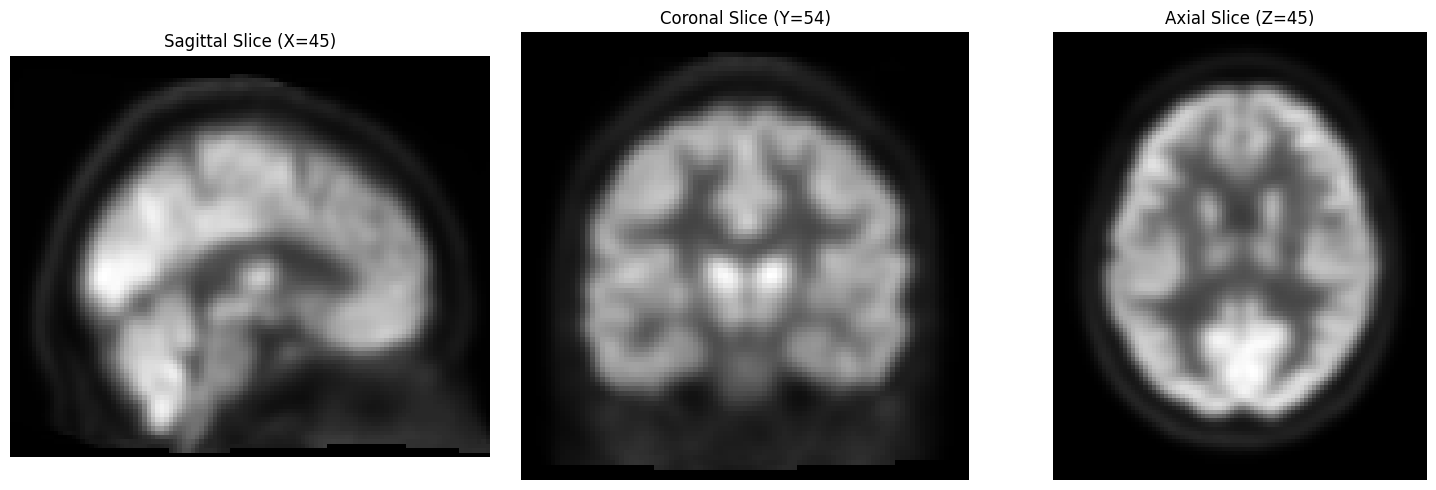

In [6]:
# Verify data with a test sample
i = 0
for data, label in train_data:
    view_image_data(data[i])
    #data[i] = torch.flip(data[i], dims=[3])
    #view_image_data(data[i])
    print(data[i].shape)
    max_val = data[i].max()
    min_val = data[i].min()
    print(f"Min value: {min_val}, Max value: {max_val}")
    break

# Nested Cross-Validation

In [ ]:
# ----- Hyperparameter Tuning with K-Fold Cross-Validation -----

N_SPLITS = 5 # Number of splits for cross-validation
NUM_EPOCHS = 200 # Number of epochs for training
EARLY_STOP_PATIENCE = 20 # Patience for early stopping

learning_rates = [2e-7] # Learning rates to test
weight_decays = [2e-3] # Weight decays to test

RESULTS_BASE_DIR = "/home/diogommiranda/tese/outputs/ResNet/" + dir0 + DATASET + "/fixed_lr/" + str(BATCH_SIZE) + "B/" # Directory to save results

os.makedirs(RESULTS_BASE_DIR, exist_ok=True)
print(f"Results will be saved to: {RESULTS_BASE_DIR}")

# Set up StratifiedGroupKFold by subjects
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
subject_ids_list = [extract_subject_id(p) for p in train_paths]
subject_ids = np.array(subject_ids_list)

overall_start_time = time.time()

for current_lr in learning_rates:
    for current_wd in weight_decays: 
        print("=" * 60)
        print(f"Testing Combination: LR={current_lr:.1e}, WeightDecay={current_wd:.0e}")
        start_time_combination = time.time()

        combo_dir_name = f"LR_{current_lr:.1e}_WD_{current_wd:.0e}_NESTED_CV"
        combo_results_dir = os.path.join(RESULTS_BASE_DIR, combo_dir_name)

        if os.path.exists(combo_results_dir):
            print(f"\nDirectory {combo_results_dir} already exists. Skipping...\n")
            continue
        
        os.makedirs(combo_results_dir, exist_ok=True)
        print(f"  Saving results for this combo to: {combo_results_dir}")
        print("=" * 60)

        current_combo_val_losses = []
        current_combo_val_accuracies = []
        current_combo_val_aucs = []
        current_combo_best_epoch = []
        
        current_combo_val_sensitivities = []
        current_combo_val_specificities = []
        current_combo_val_baccs = []
        current_combo_val_f1s = []
        current_combo_val_mccs = []

        current_combo_test_losses = []
        current_combo_test_accuracies = []
        current_combo_test_aucs = []
        
        current_combo_test_sensitivities = []
        current_combo_test_specificities = []
        current_combo_test_baccs = []
        current_combo_test_f1s = []
        current_combo_test_mccs = []

        fold_no = 1

        # ----- K-Fold Cross-Validation -----
        for train_indices, val_indices in sgkf.split(train_paths, train_labels, groups=subject_ids):
            print("-" * 60)
            print(f"Training Fold {fold_no}/{N_SPLITS} for LR={current_lr:.1e} and WD={current_wd:.0e}...")
            start_time_fold = time.time()

            # Get paths and labels for the current fold
            fold_train_paths = train_paths[train_indices]
            fold_train_labels = train_labels[train_indices]
            fold_val_paths = train_paths[val_indices]
            fold_val_labels = train_labels[val_indices]

            # Verify subject separation
            train_subjects = set(subject_ids[train_indices])
            val_subjects = set(subject_ids[val_indices])
            if not train_subjects.isdisjoint(val_subjects):
                    raise RuntimeError(f"WARNING: Fold {fold_no} has overlapping subjects!")

            print(f"  Train samples: {len(fold_train_paths)}, Validation samples: {len(fold_val_paths)}")

            # Calculate intensity normalization parameters for the current training fold
            fold_min, fold_max = calculate_min_max(fold_train_paths)

            # Create fold train dataset
            fold_train_data = create_dataloader(
                paths=fold_train_paths,
                labels=fold_train_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=True, 
                seed=seed,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding,
                mask_path=ROI_MASK_PATH
            ) 
            
            # Create fold validation dataset
            fold_val_data = create_dataloader(
                paths=fold_val_paths,
                labels=fold_val_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False, 
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding,
                mask_path=ROI_MASK_PATH
            )
            
            # Create test dataset
            test_data = create_dataloader(
                paths=test_paths,
                labels=test_labels,
                batch_size=BATCH_SIZE,
                volume_shape=VOLUME_SHAPE,
                is_training=False,
                seed=None,
                min_val=fold_min, 
                max_val=fold_max,
                apply_padding=apply_padding,
                mask_path=ROI_MASK_PATH
                )

            if fold_train_data is None or fold_val_data is None or test_data is None:
                    raise RuntimeError(f"ERROR: Could not create datasets for fold {fold_no}.")
                
            # Compute class weights for the current fold
            unique_classes, class_counts = np.unique(fold_train_labels, return_counts=True)
            print(f"  Fold train label counts: {dict(zip(unique_classes, class_counts))}")
            pos_weight_val = class_counts[0] / class_counts[1]
            pos_weight_val = torch.tensor([pos_weight_val], device=device)
            print(f"  Calculated pos_weight for BCEWithLogitsLoss: {pos_weight_val.item():.4f}")

            # Create the model
            model = ResNet(
                block='basic',
                layers=[2, 2, 2, 2], # [3, 4, 6, 3] for ResNet34, [2, 2, 2, 2] for ResNet18
                block_inplanes=[64, 128, 256, 512],
                spatial_dims=3,
                n_input_channels=1,
                conv1_t_stride=2,
                num_classes=1,
                shortcut_type='B',
                bias_downsample = True
            )
            model.to(device)

            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_wd)

            best_val_loss = float('inf')
            best_val_bacc = -float('inf')
            epochs_no_improve = 0
            best_epoch = 0
            best_model_state = None
            stopped_epoch = NUM_EPOCHS 

            # Initialize history for this fold
            history = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [], 'val_loss': [], 'val_accuracy': [], 'val_auc': [],
                               'val_sensitivity': [], 'val_specificity': [], 'val_bacc': [], 'val_f1': [], 'val_mcc': []}

            for epoch in tqdm(range(NUM_EPOCHS)):
                epoch_start_time = time.time()
                history['epoch'].append(epoch + 1)

                # --- Train phase ---
                model.train()
                
                running_loss = 0.0
                train_pred_probs = []
                train_targets = []
                
                for i, (inputs, labels) in enumerate(fold_train_data):
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)
                    
                    optimizer.zero_grad()
                    
                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()

                    running_loss += loss.item() * inputs.size(0)
                    
                    prob_outputs = torch.sigmoid(outputs)
                    train_pred_probs.extend(prob_outputs.detach().cpu().numpy())
                    train_targets.extend(labels.detach().cpu().numpy())

                train_targets = np.array(train_targets).flatten()
                train_pred_probs = np.array(train_pred_probs).flatten()
                
                # Calculate training metrics for the epoch
                train_loss = running_loss / len(fold_train_data.dataset)
                train_acc = accuracy_score(train_targets, train_pred_probs >= 0.5)
                train_auc = roc_auc_score(train_targets, train_pred_probs)
                history['train_loss'].append(train_loss)
                history['train_accuracy'].append(train_acc)
                history['train_auc'].append(train_auc)

                # --- Validation phase ---
                model.eval()
                val_running_loss = 0.0
                val_pred_probs = []
                val_targets = []

                with torch.inference_mode():
                    for inputs, labels in fold_val_data:
                        inputs = inputs.to(device)
                        labels = labels.float().unsqueeze(1).to(device)

                        # Mixed precision
                        with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)

                        val_running_loss += loss.item() * inputs.size(0)

                        prob_outputs = torch.sigmoid(outputs)
                        val_pred_probs.extend(prob_outputs.cpu().numpy())
                        val_targets.extend(labels.cpu().numpy())
                        
                val_targets = np.array(val_targets).flatten()
                val_pred_probs = np.array(val_pred_probs).flatten()

                # Calculate validation metrics for the epoch
                val_loss = val_running_loss / len(fold_val_data.dataset)
                val_acc = accuracy_score(val_targets, val_pred_probs >= 0.5)
                val_auc = roc_auc_score(val_targets, val_pred_probs)
                
                val_true = val_targets.astype(int)
                val_pred = (val_pred_probs >= 0.5).astype(int)
                
                val_sensitivity = recall_score(val_true, val_pred, pos_label=1)
                val_specificity = recall_score(val_true, val_pred, pos_label=0)
                val_bacc = balanced_accuracy_score(val_true, val_pred)
                val_f1 = f1_score(val_true, val_pred, average='weighted')
                val_mcc = matthews_corrcoef(val_true, val_pred)
                
                
                history['val_loss'].append(val_loss)
                history['val_accuracy'].append(val_acc)
                history['val_auc'].append(val_auc)
                
                history['val_sensitivity'].append(val_sensitivity)
                history['val_specificity'].append(val_specificity)
                history['val_bacc'].append(val_bacc)
                history['val_f1'].append(val_f1)
                history['val_mcc'].append(val_mcc)

                # Print Epoch Summary
                epoch_duration = time.time() - epoch_start_time
                #print(f"    Epoch {epoch+1}/{NUM_EPOCHS} [{epoch_duration:.2f}s] - "
                #        f"Train Loss: {train_loss:.5f}, Train Acc: {train_acc:.5f} | "
                #        f"Val Loss: {val_loss:.5f}, Val Acc: {val_acc:.5f}")
                

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                    # Save the model state with the lowest validation loss
                    best_model_state = model.state_dict()
                    best_epoch = epoch + 1

                if epochs_no_improve >= EARLY_STOP_PATIENCE:
                    model.load_state_dict(best_model_state)
                    print(f"\nEarly stopping triggered. Restoring best model weights from epoch {best_epoch}.\n")
                    break
            
            # Restore the best model state if early stopping was not triggered
            if epochs_no_improve < EARLY_STOP_PATIENCE:
                print(f"Training completed for {NUM_EPOCHS} epochs. Restoring best model weights from epoch {best_epoch}.")
                model.load_state_dict(best_model_state)
            
            # Save fold history and plots
            fold_dir = os.path.join(combo_results_dir, f"fold_{fold_no}")
            os.makedirs(fold_dir, exist_ok=True)
            history_df = pd.DataFrame(history)
            history_csv_path = os.path.join(fold_dir, f"history_fold_{fold_no}.csv")
            history_df.to_csv(history_csv_path, index=False)
            plot_loss_curves(history, fold_dir)

            best_epoch_index = best_epoch - 1
            
            val_loss_best = history['val_loss'][best_epoch_index]
            val_accuracy_best = history['val_accuracy'][best_epoch_index]
            val_auc_best = history['val_auc'][best_epoch_index]
            
            val_sensitivity_best = history['val_sensitivity'][best_epoch_index]
            val_specificity_best = history['val_specificity'][best_epoch_index]
            val_bacc_best = history['val_bacc'][best_epoch_index]
            val_f1_best = history['val_f1'][best_epoch_index]
            val_mcc_best = history['val_mcc'][best_epoch_index]
            
            print(f"    Fold {fold_no} - Best Epoch {best_epoch}, Val Loss: {val_loss_best:.4f}, Acc: {val_accuracy_best:.4f}, AUC: {val_auc_best:.4f}, \n"
                    f"    Sensitivity: {val_sensitivity_best:.4f}, Specificity: {val_specificity_best:.4f}, BACC: {val_bacc_best:.4f}, F1: {val_f1_best:.4f}, MCC: {val_mcc_best:.4f}")

            # Append results for this fold
            current_combo_val_losses.append(val_loss_best)
            current_combo_val_accuracies.append(val_accuracy_best)
            current_combo_val_aucs.append(val_auc_best)
            current_combo_best_epoch.append(best_epoch)
            
            current_combo_val_sensitivities.append(val_sensitivity_best)
            current_combo_val_specificities.append(val_specificity_best)
            current_combo_val_baccs.append(val_bacc_best)
            current_combo_val_f1s.append(val_f1_best)
            current_combo_val_mccs.append(val_mcc_best)
            
            optimizer_name = optimizer.__class__.__name__
            
            end_time_fold = time.time()
            print(f"    Fold {fold_no} finished in {end_time_fold - start_time_fold:.2f} seconds.")
            fold_no += 1
            
            # Save the validation metrics for current fold
            val_metrics_file_path = os.path.join(fold_dir, "val_results.txt")
            with open(val_metrics_file_path, "w") as f:
                f.write("--- Validation Metrics ---\n")
                f.write(f"Loss:        {val_loss_best:.4f}\n")
                f.write(f"Accuracy:    {val_accuracy_best:.4f}\n")
                f.write(f"Sensitivity: {val_sensitivity_best:.4f}\n")
                f.write(f"Specificity: {val_specificity_best:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {val_bacc_best:.4f}\n")
                f.write(f"F1 Score (Weighted):      {val_f1_best:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {val_mcc_best:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {val_auc_best:.4f}\n")
            
            # --- Evaluate the model on the test data ---
            model.eval()
            test_running_loss = 0.0
            test_pred_probs = []
            test_targets = []

            with torch.inference_mode():
                for inputs, labels in test_data:
                    inputs = inputs.to(device)
                    labels = labels.float().unsqueeze(1).to(device)

                    # Mixed precision
                    with torch.autocast(device_type=device.type, dtype=torch.float16, enabled=USE_AMP):
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    test_running_loss += loss.item() * inputs.size(0)
                
                    prob_outputs = torch.sigmoid(outputs)
                    
                    test_pred_probs.extend(prob_outputs.cpu().numpy())
                    test_targets.extend(labels.cpu().numpy())

            test_targets = np.array(test_targets).flatten()
            test_pred_probs = np.array(test_pred_probs).flatten()

            # Calculate test loss and accuracy
            test_loss = test_running_loss / len(test_data.dataset)
            test_acc = accuracy_score(test_targets, test_pred_probs >= 0.5)

            y_true = test_targets.astype(int)
            y_pred = (test_pred_probs >= 0.5).astype(int)

            # Calculate metrics
            test_sensitivity = recall_score(y_true, y_pred, pos_label=1)
            test_specificity = recall_score(y_true, y_pred, pos_label=0)
            test_bacc = balanced_accuracy_score(y_true, y_pred)
            test_f1 = f1_score(y_true, y_pred, average='weighted')
            test_mcc = matthews_corrcoef(y_true, y_pred)
            test_auc_score = roc_auc_score(y_true, y_pred)
            
            print(f"    Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}, AUC: {test_auc_score:.4f}, \n"
                  f"    Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}, BACC: {test_bacc:.4f}, F1: {test_f1:.4f}, MCC: {test_mcc:.4f}")
            
            classes = DATASET.split("_")
            class0, class1 = classes[0], classes[1]
            target_names = [class0, class1]

            # Save the confusion matrix plot
            make_confusion_matrix(y_true=y_true,
                                y_pred=y_pred,
                                classes=target_names,
                                figsize=(8, 8),
                                text_size=15,
                                save_dir=fold_dir)

            # Save the test loss and accuracy and the evaluation metrics
            result_file_path = os.path.join(fold_dir, "test_results.txt")
            with open(result_file_path, "w") as f:
                f.write(f"[{test_loss}, {test_acc}]\n\n")
                f.write("--- Evaluation Metrics on Test Set ---\n")
                f.write(f"Accuracy:    {test_acc:.4f}\n")
                f.write(f"Sensitivity: {test_sensitivity:.4f}\n")
                f.write(f"Specificity: {test_specificity:.4f}\n")
                f.write(f"Balanced Accuracy (BACC): {test_bacc:.4f}\n")
                f.write(f"F1 Score (Weighted):      {test_f1:.4f}\n")
                f.write(f"Matthews Corr Coef (MCC): {test_mcc:.4f}\n")
                f.write(f"Area Under the Curve (AUC): {test_auc_score:.4f}\n")
                
            test_config = {
                "num_epochs": int(best_epoch),
                "optimizer": optimizer_name,
                "optimizer_params": {
                    "lr": float(current_lr),
                    "weight_decay": float(current_wd)
                },
                "batch_size": BATCH_SIZE,
                "seed": seed,
                "dataset": DATASET
            }
            params_file_path = os.path.join(fold_dir, "test_config.json")
            with open(params_file_path, "w") as f:
                json.dump(test_config, f, indent=4)
                    
            # Append results for this fold
            current_combo_test_losses.append(test_loss)
            current_combo_test_accuracies.append(test_acc)
            current_combo_test_aucs.append(test_auc_score)
            
            current_combo_test_sensitivities.append(test_sensitivity)
            current_combo_test_specificities.append(test_specificity)
            current_combo_test_baccs.append(test_bacc)
            current_combo_test_f1s.append(test_f1)
            current_combo_test_mccs.append(test_mcc)
            
            # Free resources
            del model, optimizer, criterion, fold_train_data, fold_val_data, history, history_df, best_model_state
            if device.type == 'cuda':
                torch.cuda.empty_cache() 
            gc.collect() 

        end_time_combination = time.time()
        print(f"Combination finished in {end_time_combination - start_time_combination:.2f} seconds.")

        # Aggregate results across folds
        avg_loss = np.mean(current_combo_val_losses)
        std_loss = np.std(current_combo_val_losses)
        avg_acc = np.mean(current_combo_val_accuracies)
        std_acc = np.std(current_combo_val_accuracies)
        avg_auc = np.mean(current_combo_val_aucs)
        std_auc = np.std(current_combo_val_aucs)
        
        avg_sensitivity = np.mean(current_combo_val_sensitivities)
        avg_specificity = np.mean(current_combo_val_specificities)
        avg_bacc = np.mean(current_combo_val_baccs)
        std_bacc = np.std(current_combo_val_baccs)
        avg_f1 = np.mean(current_combo_val_f1s)
        std_f1 = np.std(current_combo_val_f1s)
        avg_mcc = np.mean(current_combo_val_mccs)

        combo_average_results = {
            'avg_val_loss': avg_loss,
            'std_val_loss': std_loss,
            'avg_val_accuracy': avg_acc,
            'std_val_accuracy': std_acc,
            'avg_val_auc': avg_auc,
            'std_val_auc': std_auc,
            'individual_losses': [round(loss, 4) for loss in current_combo_val_losses],
            'individual_accuracies': [round(acc, 4) for acc in current_combo_val_accuracies],
            'individual_aucs': [round(auc, 4) for auc in current_combo_val_aucs],
            'best_epoch_per_fold': list(current_combo_best_epoch),
            'avg_val_sensitivity': avg_sensitivity,
            'avg_val_specificity': avg_specificity,
            'avg_val_bacc': avg_bacc,
            'std_val_bacc': std_bacc,
            'avg_val_f1': avg_f1,
            'std_val_f1': std_f1,
            'avg_val_mcc': avg_mcc,
            'individual_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_val_sensitivities],
            'individual_specificities': [round(specificity, 4) for specificity in current_combo_val_specificities],
            'individual_baccs': [round(bacc, 4) for bacc in current_combo_val_baccs],
            'individual_f1s': [round(f1, 4) for f1 in current_combo_val_f1s],
            'individual_mccs': [round(mcc, 4) for mcc in current_combo_val_mccs],
        }

        # Save results in a txt file and the parameters in a json file
        val_results_df = pd.DataFrame(combo_average_results)
        display_cols = list(combo_average_results.keys())

        val_results_filepath = os.path.join(combo_results_dir, "validation_results.txt")
        with open(val_results_filepath, "w") as f:
            print("Validation Results Summary:", file=f)
            print(val_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        avg_test_loss = np.mean(current_combo_test_losses)
        std_test_loss = np.std(current_combo_test_losses)
        avg_test_acc = np.mean(current_combo_test_accuracies)
        std_test_acc = np.std(current_combo_test_accuracies)
        avg_test_auc = np.mean(current_combo_test_aucs)
        std_test_auc = np.std(current_combo_test_aucs)
        
        avg_test_sensitivity = np.mean(current_combo_test_sensitivities)
        std_test_sensitivity = np.std(current_combo_test_sensitivities)
        avg_test_specificity = np.mean(current_combo_test_specificities)
        std_test_specificity = np.std(current_combo_test_specificities)
        avg_test_bacc = np.mean(current_combo_test_baccs)
        std_test_bacc = np.std(current_combo_test_baccs)
        avg_test_f1 = np.mean(current_combo_test_f1s)
        std_test_f1 = np.std(current_combo_test_f1s)
        avg_test_mcc = np.mean(current_combo_test_mccs)
        std_test_mcc = np.std(current_combo_test_mccs)

        combo_test_average_results = {
            'avg_test_loss': avg_test_loss,	
            'std_test_loss': std_test_loss,
            'avg_test_accuracy': avg_test_acc,
            'std_test_accuracy': std_test_acc,
            'avg_test_auc': avg_test_auc,
            'std_test_auc': std_test_auc,
            'individual_test_losses': [round(loss, 4) for loss in current_combo_test_losses],
            'individual_test_accuracies': [round(acc, 4) for acc in current_combo_test_accuracies],
            'individual_test_aucs': [round(auc, 4) for auc in current_combo_test_aucs],
            'avg_test_sensitivity': avg_test_sensitivity,
            'std_test_sensitivity': std_test_sensitivity,
            'avg_test_specificity': avg_test_specificity,
            'std_test_specificity': std_test_specificity,
            'avg_test_bacc': avg_test_bacc,
            'std_test_bacc': std_test_bacc,
            'avg_test_f1': avg_test_f1,
            'std_test_f1': std_test_f1,
            'avg_test_mcc': avg_test_mcc,
            'std_test_mcc': std_test_mcc,
            'individual_test_sensitivities': [round(sensitivity, 4) for sensitivity in current_combo_test_sensitivities],
            'individual_test_specificities': [round(specificity, 4) for specificity in current_combo_test_specificities],
            'individual_test_baccs': [round(bacc, 4) for bacc in current_combo_test_baccs],
            'individual_test_f1s': [round(f1, 4) for f1 in current_combo_test_f1s],
            'individual_test_mccs': [round(mcc, 4) for mcc in current_combo_test_mccs],
        }
            
        test_results_df = pd.DataFrame(combo_test_average_results)
        display_cols = list(combo_test_average_results.keys())
        test_results_filepath = os.path.join(combo_results_dir, "average_test_results.txt")
        with open(test_results_filepath, "w") as f:
            print("Test Results Summary:", file=f)
            print(test_results_df[display_cols].round(6).to_string(index=False, max_colwidth=None, line_width=250), file=f)

            print(f"\nHyperparameters: LR={current_lr:.1e}, Weight_decay={current_wd:.0e}", file=f)

        training_config = {
            "num_folds": N_SPLITS,
            "num_epochs": NUM_EPOCHS,
            "early_stop_patience": EARLY_STOP_PATIENCE,
            "optimizer": optimizer_name,
            "optimizer_params": {
                "lr": float(current_lr),
                "weight_decay": float(current_wd)
            }, 
            "batch_size": BATCH_SIZE,
            "seed": seed,
            "dataset": DATASET
        }
        params_file_path = os.path.join(combo_results_dir, "training_config.json")
        with open(params_file_path, "w") as f:
            json.dump(training_config, f, indent=4)

NameError: name 'dir0' is not defined